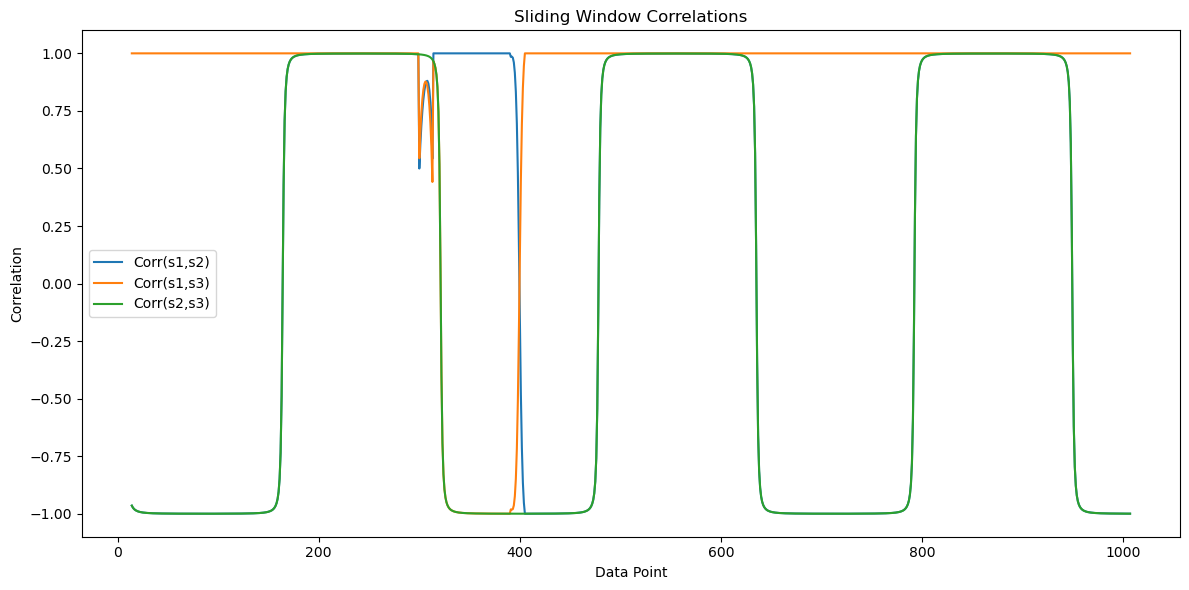

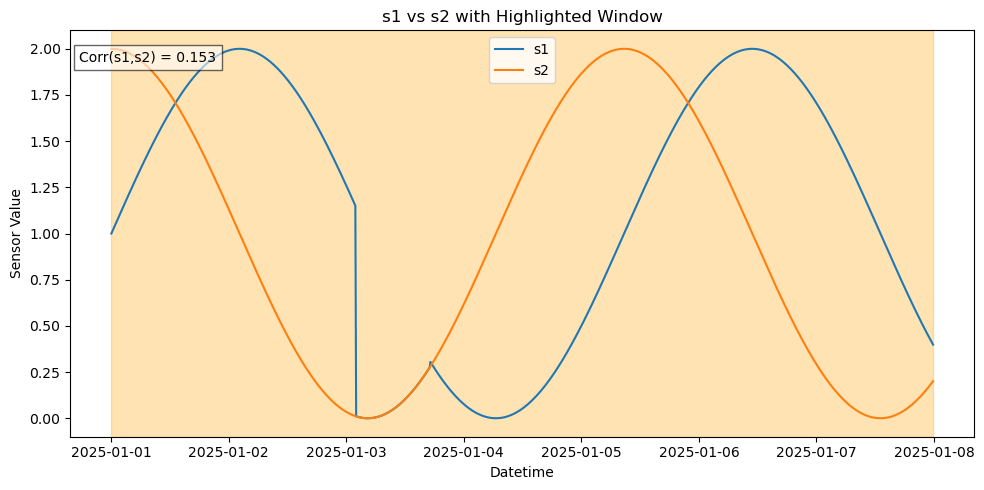

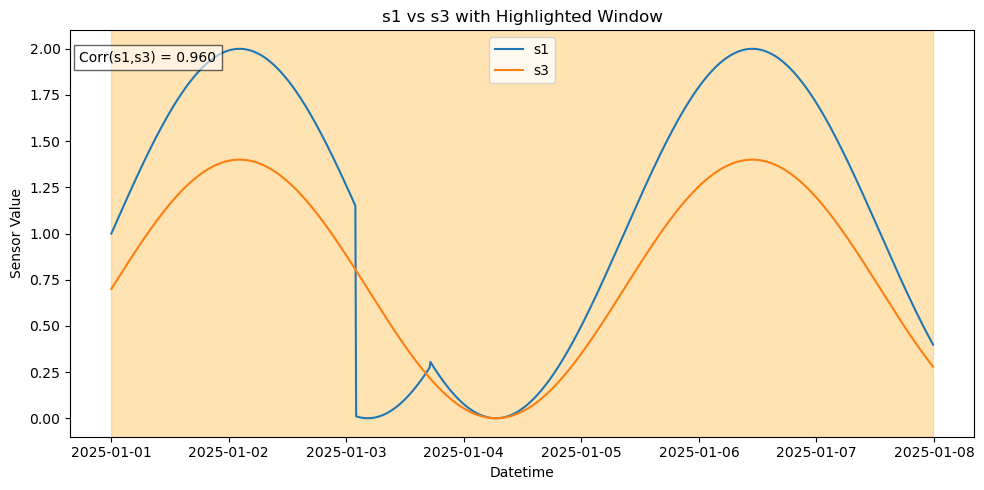

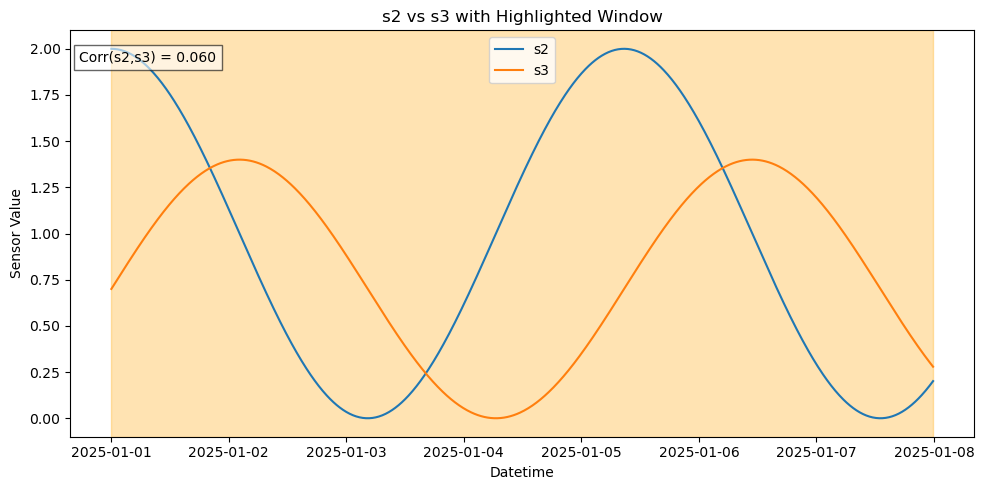

Saved: complex_formatted.csv


In [5]:
from data_loader import load_data
from normalization import normalize_data
from sliding_correlations import compute_sliding_correlations
from correlation import compute_correlation_in_window
from plotting_correlation import plot_all_correlations
from plotting_streams import plot_pairwise_highlighted
from save_to_csv import save_correlations
from gui_setup import setup_gui
from datetime import datetime
import os

def process_callback(window_size_box,
                     start_date, start_hour, start_minute, start_second,
                     end_date, end_hour, end_minute, end_second,
                     stream_vars):
    """
    Callback function triggered when the user clicks the 'Display' button in the GUI.
    Handles the extraction of user input, computation of correlations, visualization,
    and saving of results.

    Parameters:
        window_size_box (Entry): Entry widget containing the sliding window size.
        start_date, end_date (DateEntry): Start and end date selectors.
        start_hour, start_minute, start_second (Combobox): Start time selectors.
        end_hour, end_minute, end_second (Combobox): End time selectors.
        stream_vars (dict): Dictionary of sensor stream BooleanVars indicating user selection.

    Returns:
        None
    """
    # --- Parse and validate window size ---
    try:
        window_size = int(window_size_box.get())
    except ValueError:
        print("Invalid window size")
        return

    # --- Extract selected sensor columns ---
    selected_streams = [stream for stream, var in stream_vars.items() if var.get()]
    df_selected = df_raw[["data_point", "datetime"] + selected_streams]

    # --- Normalize selected data ---
    df_normalized = normalize_data(df_selected, time_col="data_point")

    # --- Compute sliding window correlations ---
    correlations = compute_sliding_correlations(df_normalized, window_size)

    # --- Plot correlation curves for all pairs ---
    plot_all_correlations(df_normalized, correlations, window_size)

    # --- Parse datetime ranges from GUI ---
    start_dt = datetime.combine(start_date.get_date(), datetime.strptime(
        f"{start_hour.get()}:{start_minute.get()}:{start_second.get()}", "%H:%M:%S").time())
    end_dt = datetime.combine(end_date.get_date(), datetime.strptime(
        f"{end_hour.get()}:{end_minute.get()}:{end_second.get()}", "%H:%M:%S").time())

    # --- Plot selected pairs with the highlighted datetime window ---
    plot_pairwise_highlighted(df_normalized, selected_streams, start_dt, end_dt)

    # --- Save correlation results to CSV file ---
    save_correlations(df_normalized, correlations, output_dir=os.path.dirname("complex.csv"))


# ---------- Load Data ----------
# Load the initial dataset and derive datetime boundaries for the GUI
df_raw, min_dp, max_dp, time_col = load_data("complex.csv")
min_datetime = df_raw["datetime"].min()
max_datetime = df_raw["datetime"].max()

# Launch the GUI with dynamically constrained date/time selection
setup_gui(min_datetime, max_datetime, process_callback)
